# Allen GNN using exp data

### By Jianfeng Ke
#### 02/26/20234

In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

In [2]:
import os
import csv
import copy
import math
import time
import random
import argparse
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from scipy import stats
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [3]:
# initial settings
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pick_gtex_region = 'Amygdala'
# pick_gtex_region = 'Anterior_cingulate_cortex_BA24'
# pick_gtex_region = 'Caudate_basal_ganglia'
# pick_gtex_region = 'Cerebellar_Hemisphere'
# pick_gtex_region = 'Frontal_Cortex_BA9'
# pick_gtex_region = 'Hippocampus'
# pick_gtex_region = 'Hypothalamus'
# pick_gtex_region = 'Nucleus_accumbens_basal_ganglia'
# pick_gtex_region = 'Putamen_basal_ganglia'
# pick_gtex_region = 'Substantia_nigra'

# name difference
if pick_gtex_region=='Cerebellar_Hemisphere':
    allen_name='Cerebellum'
elif pick_gtex_region=='Frontal_Cortex_BA9':
    allen_name='Cortex'
else:
    allen_name=pick_gtex_region

# settings
all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']

# path
allen_data_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/allen/'
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'

GeneExpression_allen_dict = {}
# iterate over all 6 subjects
for i in range(len(all_ids)):
    donor = all_ids[i]
    file_name = save_path + "normalized_expr_" + donor + ".csv"
    normalized_mat = pd.read_csv(file_name, header = 0)
    normalized_mat = normalized_mat.set_index('gene_symbol')
    GeneExpression_allen_dict[donor] = normalized_mat

In [4]:
GeneExpression_allen_dict['9861']

,4012,4013,4014,4023,4024,4030,4031,4039,4045,4048,...,9161,9492,9520,9543,9561,9598,9614,9677,9698,13005
gene_symbol,,,,,,,,,,,,,,,,,,,,,
61E3.4,-0.136085,-0.570544,-0.382100,-0.581447,-0.378888,-0.916947,-0.232627,-0.547712,-0.367621,-0.601237,...,-1.052964,-0.584626,-0.694246,0.289274,0.319522,0.484582,-0.760618,0.080470,1.074124,-2.641711
A1BG,-0.829803,-0.837572,-0.802058,-0.276539,-0.214125,0.006190,-0.680771,-0.793143,-1.369972,-0.020326,...,0.340752,-0.986939,-2.394058,1.230693,0.729546,0.251698,1.211385,0.492374,0.717822,-1.521538
A1CF,0.076065,0.209908,0.373509,0.417645,0.834311,0.515172,0.218465,-0.044562,-0.252439,0.778563,...,1.433750,0.461429,0.256370,1.038874,0.460762,0.067577,1.710397,1.098084,0.676102,0.702596
A26C1B,-0.028601,0.253801,0.791809,0.019451,-0.168744,0.179723,0.263563,0.116223,-0.016212,-0.195048,...,-0.603095,-0.302020,-1.253113,-1.247258,-0.363701,-0.270167,-1.095872,-0.331897,-0.006372,-2.590186
A2BP1,0.676023,0.580556,0.318220,0.155971,0.214212,0.245690,0.356752,-0.057667,0.397180,0.299008,...,-0.892509,-0.250031,-0.569205,-0.417356,-0.013207,-0.450274,-1.055488,0.260256,-1.022606,-0.988585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,-0.418638,0.088653,0.234413,0.056923,0.318242,0.089120,0.023038,-0.360018,0.178378,0.077464,...,1.025997,0.821059,0.522869,2.396599,1.197943,0.780386,1.259527,0.702824,0.171106,1.659898
ZYG11B,0.203986,0.317840,-0.246051,-0.009711,-0.037225,-0.089917,-0.113157,-0.209170,0.718603,0.101703,...,-0.634346,-0.296952,-0.835908,-1.506753,-1.407445,-0.681088,-1.346105,-1.757144,-1.090335,-1.275621
ZYX,0.671222,0.256665,0.495753,-0.121747,0.058862,0.182311,0.218112,-0.031382,0.149754,-0.280373,...,-0.713819,1.351224,1.180874,0.136091,-0.385688,0.665641,0.186633,-0.215835,1.064519,-2.014772


### find the allen regions used to generate summarized gtex info

In [5]:
ontology_path = allen_data_path + 'normalized_microarray_donor' + '9861' + '/Ontology.csv'
ontology = pd.read_csv(ontology_path, header = 0)
# From the ontology file, find the sub-regions in allen under gtex region
gtex_map_path = allen_data_path + "map_gtex_structure.txt"
gTex_map_dict = {}
print("Total number of regions in allen ontology:", ontology.shape[0])
for i in open(gtex_map_path):
    i = i.strip().split("\t")
    gtex_region = i[0].strip()
    allen_region = i[1].strip()
    if((allen_region == "none?") | (allen_region == 'pituitary body')):
        continue
    covered_allen_region = ontology.loc[(ontology['name']==allen_region) | ontology['structure_id_path'].str.startswith(ontology.loc[ontology['name']==allen_region, 'structure_id_path'].values[0]), 'id']
    gTex_map_dict[gtex_region] = covered_allen_region.tolist()
    print(gtex_region, "-->", allen_region, ";  number of regions in allen:", len(covered_allen_region))

Total number of regions in allen ontology: 1839
Amygdala --> amygdala ;  number of regions in allen: 135
Anterior_cingulate_cortex_BA24 --> cingulate gyrus, frontal part ;  number of regions in allen: 7
Caudate_basal_ganglia --> caudate nucleus ;  number of regions in allen: 10
Cerebellum --> cerebellum ;  number of regions in allen: 95
Cortex --> frontal lobe ;  number of regions in allen: 87
Hippocampus --> hippocampal formation ;  number of regions in allen: 30
Hypothalamus --> hypothalamus ;  number of regions in allen: 176
Nucleus_accumbens_basal_ganglia --> nucleus accumbens ;  number of regions in allen: 3
Putamen_basal_ganglia --> putamen ;  number of regions in allen: 3
Substantia_nigra --> substantia nigra ;  number of regions in allen: 7


In [6]:
intersected_region = GeneExpression_allen_dict['9861'].columns.tolist()
used_intersected_region_dict = {}
# unseen_intersected_region_dict = {}
for gtex_region, covered_allen_region in gTex_map_dict.items():
    used_region_list = [x for x in intersected_region if int(x) in covered_allen_region]
    used_intersected_region_dict[gtex_region] = used_region_list
    print(gtex_region, " # regions expired:", len(used_region_list))
num_used_region = sum(len(value) for value in used_intersected_region_dict.values())
print("Total number of intersected region between allen and gtex:", len(intersected_region))
print("Total number of used allen region for generating regions for gtex:", num_used_region)
print("Total number of unseen allen regions when generating regions for gtex:", len(intersected_region)-num_used_region)

Amygdala  # regions expired: 6
Anterior_cingulate_cortex_BA24  # regions expired: 2
Caudate_basal_ganglia  # regions expired: 3
Cerebellum  # regions expired: 9
Cortex  # regions expired: 14
Hippocampus  # regions expired: 6
Hypothalamus  # regions expired: 3
Nucleus_accumbens_basal_ganglia  # regions expired: 1
Putamen_basal_ganglia  # regions expired: 1
Substantia_nigra  # regions expired: 2
Total number of intersected region between allen and gtex: 103
Total number of used allen region for generating regions for gtex: 47
Total number of unseen allen regions when generating regions for gtex: 56


In [7]:
used_intersected_region_dict['Amygdala']

['4329', '4342', '4351', '4360', '4367', '4379']

### Summarized gtex info

In [8]:
# read the summarized allen data (in gtex format) into a dictionary
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'
# find the file and read it into a dictionary
summarized_gtex_dict = {}
for file_name in os.listdir(save_path):
    if file_name.endswith('-gtex.txt'):
        key = file_name.split('-gtex.txt')[0]
        file_path = os.path.join(save_path, file_name)
        mat = pd.read_csv(file_path, sep='\t', index_col=0)
        #mat = mat.iloc[:-1]
        # Store the dataframe in the dictionary with the key
        summarized_gtex_dict[key] = mat

In [9]:
summarized_gtex_dict['9861']

,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellum,Cortex,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
61E3.4,0.435983,-0.233586,-0.787574,1.049501,-0.446099,0.566650,-1.542623,-1.384484,0.008329,-1.231941
A1BG,0.273667,0.114912,-0.157624,0.510235,-0.673079,-0.359627,-1.402899,0.477999,0.486163,0.388451
A1CF,0.718998,0.047894,0.346874,1.318747,0.408256,0.357831,0.480992,0.653211,0.295392,0.982218
A26C1B,-0.504782,0.064421,-0.810828,-0.233461,0.102664,0.226620,-1.266362,-0.396754,-0.829971,-0.560854
A2BP1,0.998949,-0.163673,1.485797,-0.700779,0.314266,1.818898,-1.248491,0.769011,1.524282,-1.456829
...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.540694,0.162093,0.007702,0.229302,0.141014,0.255883,0.432720,0.077200,-0.345596,0.656666
ZYG11B,-1.051965,-0.036526,-1.873067,-0.235237,0.085852,-0.767830,-0.466957,-1.068196,-1.550972,-1.005453
ZYX,0.272997,-0.378293,-1.590360,0.961701,0.084028,0.007926,-1.391757,-2.123857,-1.454998,0.356215
ZZEF1,0.016055,-0.444921,-0.746470,0.911506,-0.609513,0.820398,0.942588,-0.584762,0.001927,0.536678


### Load Gtex dataset

In [10]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")

region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_count_dict = {}
for s in sample_subject_list:
    if s in subject_count_dict:
        subject_count_dict[s] = subject_count_dict[s] + 1
    else:
        subject_count_dict[s] = 1
        
# build a dictionary to count the freq of each region
sample_region_list = gt.loc['region'].tolist()
region_count_dict = {}
for s in sample_region_list:
    if s in region_count_dict:
        region_count_dict[s] = region_count_dict[s] + 1
    else:
        region_count_dict[s] = 1
        
# find the subjects that have all 10 regions
pick_subject = [s for s, c in subject_count_dict.items() if c==10]

# build a dictionary for exp data for each subject in gtex who has all 10 brain regions
exp_gtex_dict = {}
for subject in pick_subject:
    submat = gt[gt.columns[gt.iloc[1]==subject]]
    submat.columns = submat.loc['region',:]
    submat = submat.iloc[2:,]
    submat.index.names = ['gene_id']
    submat = submat.sort_values(by=['gene_id'])
    submat = submat[region_pick]
    # And also, transform the dataframe in gtex from strings to numbers
    submat = submat.apply(pd.to_numeric, errors='ignore')
    # Take the average if more than 1 sample have the same gene names
    submat = submat.groupby(submat.index).mean()
    
    exp_gtex_dict[subject] = submat
    
# find all the ids, training ids, testing ids, in the df
sub_all_ids = list(exp_gtex_dict.keys())

In [11]:
exp_gtex_dict['GTEX-N7MT']

region,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
gene_id,,,,,,,,,,
A1BG,-0.482038,0.586791,-0.716240,-1.948896,-1.604282,-1.141839,-0.978215,0.005044,-0.031527,0.427502
A2M,1.043362,0.897944,0.800293,1.021873,0.632343,0.990496,1.759628,0.749224,1.599732,1.966025
A2ML1,0.090908,-0.846302,0.882949,0.510562,-0.382334,-0.130238,-0.390486,0.371505,-0.088376,-1.325182
A4GALT,-0.376914,0.549744,0.754241,1.032558,0.490553,0.655614,0.484873,0.472148,0.693609,0.378268
A4GNT,0.044145,-1.098164,0.643159,-0.102309,-1.098164,-0.316650,0.950118,-0.064349,-1.098164,-1.098164
...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.050457,0.757597,0.107381,-0.539507,-1.322155,-0.098508,-0.568911,0.042883,-0.455300,0.617017
ZYG11B,-0.071932,-0.349974,-0.657178,0.261428,0.466518,-0.284987,-0.056770,-0.421982,-1.220345,-1.005016
ZYX,-0.421982,-0.107381,-0.460902,0.948140,1.378633,-0.394572,-0.216018,-0.549744,-0.501962,-0.774506


### find the genes in both allen and gtex

In [12]:
# gene_module = pd.read_csv(allen_data_path+'41593_2015_BFnn4171_MOESM97_ESM.csv')
allen_gene_list = GeneExpression_allen_dict['9861'].index
gtex_gene_list = exp_gtex_dict['GTEX-N7MT'].index
overlapped_gene_list = [x for x in gtex_gene_list if x in allen_gene_list]  # 15044 genes here

# allen subject gene expression profile on the overlapped genes
exp_allen_dict = {}
for key, mat in GeneExpression_allen_dict.items():
    exp_allen_dict[key] = mat.loc[overlapped_gene_list]

# summarized gtex info for allen subjects on the overlapped genes
summ_gtex_info = {}
for key, mat in summarized_gtex_dict.items():
    summ_gtex_info[key] = mat.loc[overlapped_gene_list]
# rename the Cerebellum to Cerebellar_Hemisphere and Cortex to Frontal_Cortex_BA for allen people
for subject, mat in summ_gtex_info.items():
    mat.columns = exp_gtex_dict['GTEX-N7MT'].columns

In [13]:
summ_gtex_info['15496']

region,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
A1BG,0.234262,-0.059337,0.137776,0.397594,-0.413849,-0.149664,-0.487165,1.342822,0.833351,0.558330
A2M,0.142638,0.071698,0.934386,-0.599367,0.220077,-0.619133,-0.050719,-0.389517,1.050690,1.395456
A2ML1,-0.636792,-0.249955,-0.186545,-0.768788,-0.377603,-0.256383,-0.982446,-0.746019,-0.414880,0.490717
A4GALT,-0.290240,-0.020365,-0.634552,-0.979088,0.467329,-0.355479,-1.640867,-0.745532,-0.488030,-0.544265
A4GNT,-0.706565,-0.633189,-1.095632,-0.749619,-0.870954,-0.731410,-0.821154,-1.013480,-0.827392,-0.892790
...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.133732,0.679065,0.327810,1.712227,0.121981,-0.358244,-0.141820,0.605810,0.578556,-0.079926
ZYG11B,-0.564046,1.497329,-1.432589,0.630413,1.375957,0.122567,0.561799,-0.647631,-1.285116,-0.685567
ZYX,-1.146825,-0.022417,-1.892926,1.073050,0.340787,-1.205322,-1.173562,-1.797859,-1.699364,0.203635
ZZEF1,-0.159550,-0.211693,-0.918180,0.302041,-0.455565,-0.541797,-1.302041,-1.260901,-0.460924,0.127403


In [14]:
# As we are trying to use 9 regions to predict the 10th, we remove the column for the predicted region
summ_9_gtex_info = {}
for sub, mat in summ_gtex_info.items():
    summ_9_gtex_info[sub] = mat.drop(pick_gtex_region, axis=1)

In [15]:
exp_allen_dict['10021']

,4012,4013,4014,4023,4024,4030,4031,4039,4045,4048,...,9161,9492,9520,9543,9561,9598,9614,9677,9698,13005
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0.814204,0.286083,-0.168729,0.125791,0.159659,0.667104,0.385561,0.241987,0.899962,0.742781,...,-0.267345,-1.441550,-1.114327,0.350526,-0.307873,-0.113327,0.379669,0.611909,-0.418365,1.275733
A2M,0.558147,-0.155555,-0.106106,0.097907,-0.085118,-0.220662,0.066463,0.204968,0.030292,0.179755,...,1.099785,0.505830,0.192157,1.168836,1.467370,1.013912,1.120980,1.013456,1.537180,1.371730
A2ML1,-1.048005,-1.536504,-0.596865,-0.973612,-1.188178,-1.014881,-1.266284,-1.179009,-1.711214,-1.218320,...,0.267339,0.151981,0.166516,-0.151822,0.291815,0.049607,-0.106312,-0.057334,-0.031370,-0.411739
A4GALT,0.648656,0.641830,0.165617,0.486865,0.360249,0.728648,0.614877,0.416700,0.309523,0.700348,...,-0.391949,-0.022715,-0.153820,-0.229216,0.008655,-0.110061,-0.174774,-0.134427,-0.827152,-0.824129
A4GNT,-0.037197,0.535788,-0.069339,-0.220965,0.160995,0.047804,0.064228,0.497739,0.317460,0.623682,...,0.568362,0.028593,0.604343,0.247902,0.158403,-0.138506,0.537541,0.402388,-0.133613,-0.857304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,-0.575566,-0.464639,-0.974177,-0.131034,-0.874046,-0.404274,-0.382164,-0.240707,0.011038,-0.308454,...,-0.179595,-1.513378,-1.230714,-0.299936,-0.841711,-0.547772,-0.746350,-0.766709,-0.606747,0.382107
ZYG11B,0.060509,-0.466897,-0.267027,0.022431,0.197345,-0.103149,-0.325975,-0.354256,-0.404816,-0.167559,...,-0.971565,-0.337097,-0.877476,-1.209598,-0.715797,-1.223851,-0.932903,-1.135220,-0.848942,0.224860
ZYX,0.365514,0.595158,0.441279,0.209911,0.819061,0.256086,0.442373,0.019301,0.309645,-0.303833,...,-0.710020,1.038655,0.995666,0.460982,-1.016145,-0.744275,0.495514,-0.434027,-0.132936,-0.828880


### Find used regions and unseen regions

In [16]:
nodes_for_gtex_region = used_intersected_region_dict[allen_name]
# Create two list, one for used regions and the other for unseen regions,
used_region_list = []
for region_list in used_intersected_region_dict.values():
    used_region_list = used_region_list + region_list
unseen_region_list = [x for x in intersected_region if x not in used_region_list]
# then, we move the picked gtex region from used regions to unseen regions and not use its info in the future
unseen_region_list = unseen_region_list + nodes_for_gtex_region
used_region_list = [x for x in intersected_region if x not in unseen_region_list]

#used_regions and unseen regions indices
used_region_idx = np.sort([intersected_region.index(x) for x in used_region_list])
unseen_region_idx = np.sort([intersected_region.index(x) for x in unseen_region_list])

In [17]:
nodes_for_gtex_region

['4329', '4342', '4351', '4360', '4367', '4379']

In [18]:
len(unseen_region_idx)

62

### Gene embedding

In [19]:
g_emb_error = 0.035
g_emb_size = 2 ** 4
g_emb_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/'
g_emb_name = f'allen_gtex_gene_emb_all6subjects_size_{g_emb_size}_pearson_err_{g_emb_error}_intersected103.csv'
# np.savetxt(g_emb_path+g_emb_name, pretrain_g_emb, delimiter=',')
# read the pretrained gene embedding
pretrain_g_emb = np.genfromtxt(g_emb_path+g_emb_name, delimiter=',', dtype=np.float32)

import pickle
# Load the gene names from the file
with open(g_emb_path+g_emb_name+'_genenames.pkl', 'rb') as file:
    gene_emb_names_list = pickle.load(file)

### Build the edge list

In [20]:
# From the Ontology find the node relationship list
onto_file_path = 'normalized_microarray_donor10021/Ontology.csv'
onto_file_path = os.path.join(allen_data_path, onto_file_path)
ontology = pd.read_csv(onto_file_path)
ontology_id = ontology.loc[:, ['id', 'parent_structure_id']]
# set the parent node of 4005 to -1
ontology_id.iloc[0,1] = -1
ontology_id['parent_structure_id'] = ontology_id['parent_structure_id'].astype(int)

# View the nodes in a hierarchical way
node_child = [int(x) for x in intersected_region]
all_node = []
for i in range(1,20):
    if i==1:
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
    if len(node_child)==1:
        break
    if i!=1:
        node_parent = []
        for node in node_child:
            pos = ontology_id['id'].index[ontology_id['id']==node]
            # skip if it's already the ancestor
            if len(pos)==0: continue
            parent = ontology_id['parent_structure_id'][pos].values[0]
            node_parent.append(parent)
        node_parent = set(node_parent)
        node_child = [x for x in node_parent]
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
        
repeated_nodes = [x for y in all_node for x in y]
pick_nodes = set(repeated_nodes)
print(f"There are {len(pick_nodes)} nodes in total")

level 1: 103
[4012, 4013, 4014, 4023, 4024, 4030, 4031, 4039, 4045, 4048, 4051, 4060, 4074, 4079, 4087, 4088, 4098, 4099, 4106, 4107, 4113, 4114, 4120, 4121, 4135, 4136, 4142, 4143, 4149, 4150, 4151, 4158, 4160, 4166, 4178, 4186, 4187, 4193, 4194, 4200, 4201, 4214, 4223, 4224, 4230, 4244, 4245, 4251, 4254, 4255, 4256, 4257, 4258, 4270, 4273, 4280, 4281, 4282, 4288, 4291, 4296, 4322, 4329, 4342, 4351, 4360, 4367, 4379, 4395, 4400, 4409, 4417, 4432, 4437, 4440, 4506, 4507, 4518, 4542, 4679, 4720, 4722, 4723, 4725, 4738, 4739, 4740, 4741, 4782, 9054, 9067, 9074, 9075, 9161, 9492, 9520, 9543, 9561, 9598, 9614, 9677, 9698, 13005]
level 2: 79
[4097, 4105, 4112, 4119, 4134, 4141, 4148, 4157, 4165, 4177, 4185, 12891, 12892, 12893, 12894, 12895, 4192, 12896, 12898, 12899, 12900, 12901, 4199, 12910, 4213, 12920, 12921, 12922, 12924, 12925, 4222, 12927, 12929, 4229, 12935, 12937, 12938, 12939, 12940, 12946, 4243, 4269, 4272, 4287, 4290, 13004, 4321, 4328, 4341, 4350, 4359, 4366, 4378, 9519, 9542,

In [21]:
pick_nodes = [x for x in pick_nodes]
pick_nodes.sort()
# exclude the ancestor node (4005) and the '-1' node
intersected_nodes_child = pick_nodes[2:]
child_nodes_chr = list(exp_allen_dict['9861'].columns)
child_nodes = [int(x) for x in child_nodes_chr]
# append other hyper-level nodes to the pick_nodes
for x in intersected_nodes_child:
    if x not in child_nodes:
        child_nodes.append(x)
# find the parent nodes for the pick_nodes
parent_nodes = []
for x in child_nodes:
    pos = ontology_id['id'].index[ontology_id['id']==x][0]
    parent = ontology_id['parent_structure_id'][pos]
    parent_nodes.append(parent)

In [22]:
len(child_nodes)

243

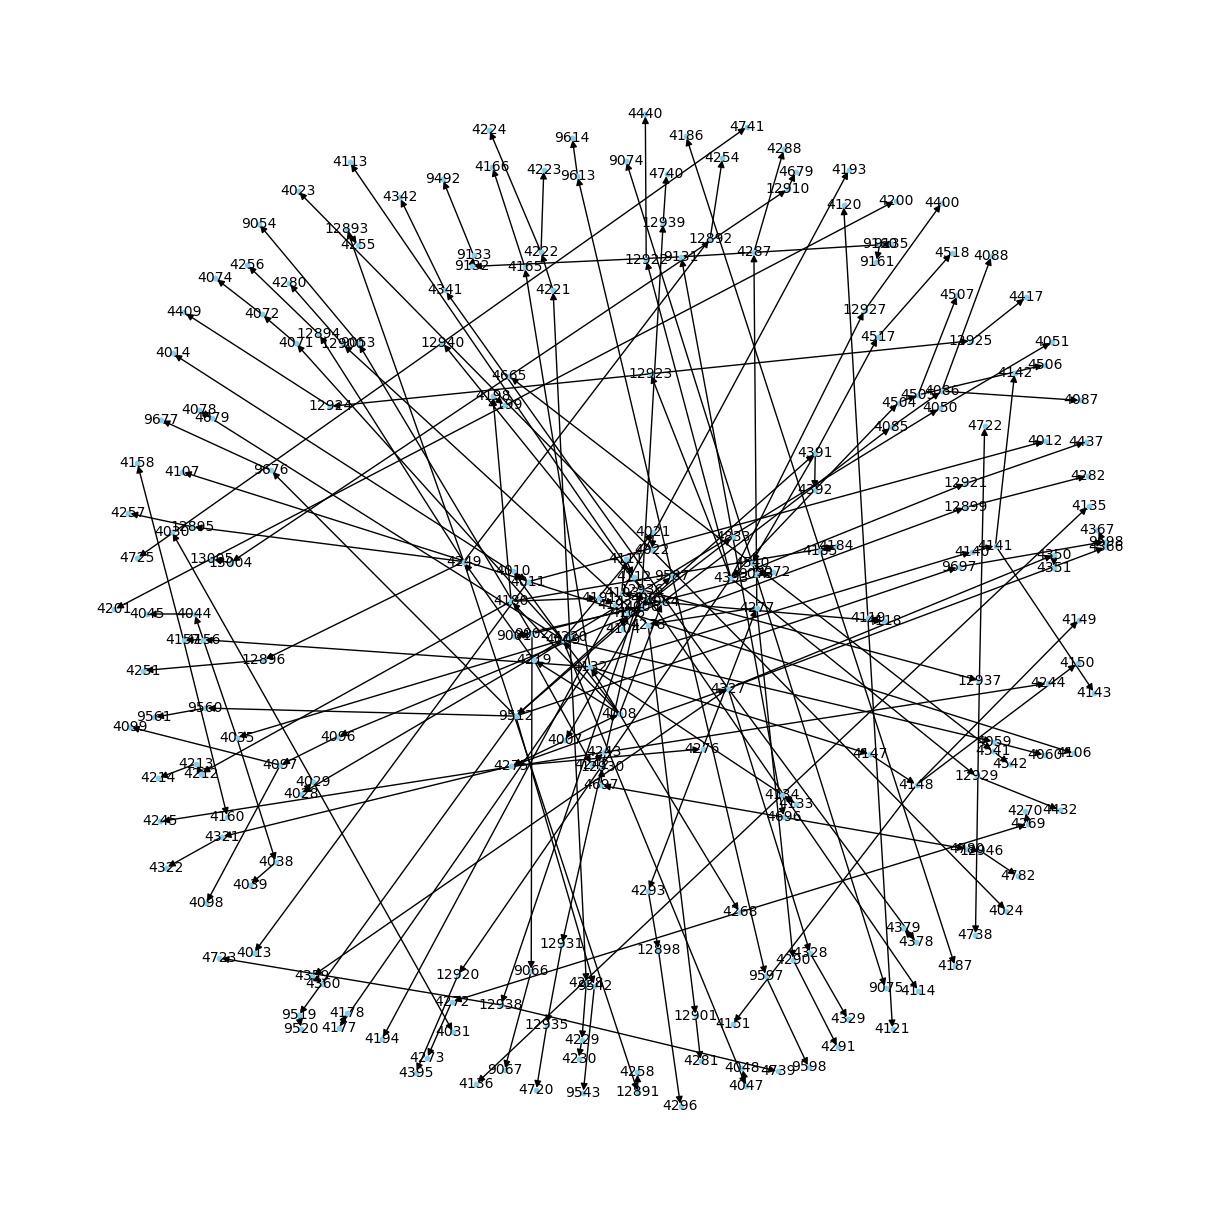

In [23]:
import networkx as nx

child_nodes = child_nodes
parent_nodes = parent_nodes

# Create a directed graph
G = nx.DiGraph()
# Add nodes and edges based on child-parent relationships
for child, parent in zip(child_nodes, parent_nodes):
    G.add_edge(parent, child)
# Create a layout for the nodes in the tree
layout = nx.spring_layout(G, seed=42)  # You can try different layout algorithms
# Define the figure size
fig = plt.figure(figsize=(12, 12))  # Adjust the width and height as needed
# Draw the graph
nx.draw(G, pos=layout, with_labels=True, node_size=10, node_color='skyblue', font_size=10, font_color='black', arrows=True)
# Show the plot
plt.show()

### trim the graph

In [24]:
for _ in range(len(parent_nodes)):
    length = len(parent_nodes)
    for i in range(length):
        cid = child_nodes[i]
        pid = parent_nodes[i]
        if pid!=4005:
            # find how many children this parent node has
            count1 = parent_nodes.count(pid)
            # if this count is more than one, we don't remove this node
            if count1 > 1:
                continue
            # if this parent node only has one child, we remove it
            else:
                # find the position of this parent node in the children node list
                pidx = child_nodes.index(pid)
                # find the grandparent
                ppid = parent_nodes[pidx]
                # remove this parent and directly connect the child to its grandparent
                child_nodes[pidx] = cid
                child_nodes.pop(i)
                parent_nodes.pop(i)
                break
    if len(parent_nodes)==length:
        break

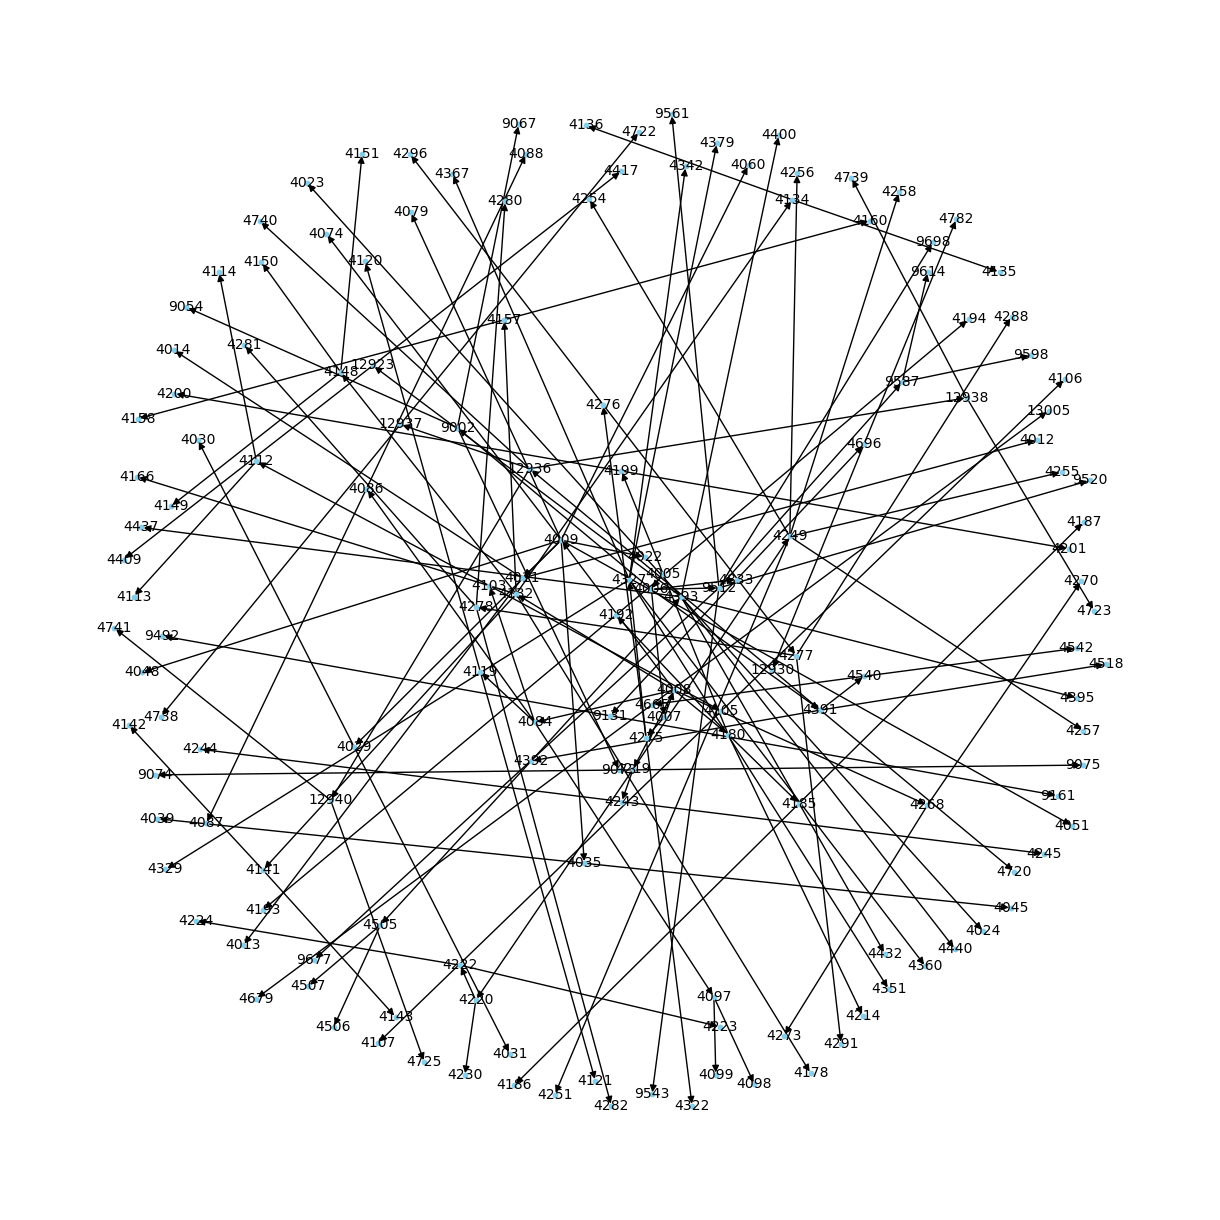

In [25]:
child_nodes = child_nodes
parent_nodes = parent_nodes

# Create a directed graph
G = nx.DiGraph()
# Add nodes and edges based on child-parent relationships
for child, parent in zip(child_nodes, parent_nodes):
    G.add_edge(parent, child)
# Create a layout for the nodes in the tree
layout = nx.spring_layout(G, seed=42)  # You can try different layout algorithms
# Define the figure size
fig = plt.figure(figsize=(12, 12))  # Adjust the width and height as needed
# Draw the graph
nx.draw(G, pos=layout, with_labels=True, node_size=10, node_color='skyblue', font_size=10, font_color='black', arrows=True)
# Show the plot
plt.show()

In [26]:
# put the leaves at the beginning
initial_nodes_chr = list(exp_allen_dict['9861'].columns)
new_child_nodes = [int(x) for x in initial_nodes_chr]
new_parent_nodes = []
for x in child_nodes:
    if x not in new_child_nodes:
        new_child_nodes.append(x)
for x in new_child_nodes:
    new_parent_nodes.append(parent_nodes[child_nodes.index(x)])

# put all nodes together in order so we can re-assign node id
all_nodes = new_child_nodes.copy()
for x in new_parent_nodes:
    if x not in all_nodes:
        all_nodes.append(x)

# re-index all the nodes and all the dataframe
child_nodes_idx = []
parent_nodes_idx = []
for node in new_child_nodes:
    child_nodes_idx.append(all_nodes.index(node))
for node in new_parent_nodes:
    parent_nodes_idx.append(all_nodes.index(node))
    
# Also get the indices for the nodes for generating the predicted gtex region
nodes_for_gtex_region = used_intersected_region_dict[allen_name]
nodes_for_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_gtex_region]

### Model pre-setting

In [27]:
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# other settings
N_gene = len(exp_allen_dict['9861'])
N_node = len(child_nodes_idx)+1

# define the edge list
# add edges between region nodes
edge_index_1 = [[child_nodes_idx[i], parent_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index_2 = [[parent_nodes_idx[i], child_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index = edge_index_1 + edge_index_2
for i in range(N_node):
    edge_index.append([i, i])

## Model: 
- predict all 103 allen regions
- Data:
  - use 5 subjects for training and 1 subjects (9861) for testing
- **concat the exp value for 10 gtex summarized regions with the embeddings**
- the feature matrix would be an identity matrix
- the region embedding comes from the GNN
- concat the region embedding, gene embedding, 10 expression values, and feed it into a MLP (or region-specific MLP) to make the prediction
- gene embedding starts with **pretrained** gene embedding
- gene embedding is **trainable** or **frozen** during the training

In [28]:
# other settings
N_gene = len(exp_allen_dict['9861'])
N_node = len(child_nodes_idx)+1
n_node = len(intersected_region)

# settings
all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
sub_all_ids = sub_all_ids

lr = 0.000001
epoch = 3
batchsize = 2048
GNN_hl1_size = 2 ** 10
r_emb_size = 2 ** 4
g_emb_size = 2 ** 4
MLP_hl1_size = 2 ** 10
MLP_hl2_size = 2 ** 6
dropout = 0.5

# we try to predict this region
pick_gtex_region = pick_gtex_region
nodes_for_gtex_region = nodes_for_gtex_region  # ['4288'] for putamen
nodes_for_gtex_region_idx = nodes_for_gtex_region_idx  # [33] for putamen

In [29]:
# Graph Ontology model structure
# define the GCN model
class child_r(torch.nn.Module):
    def __init__(self, GNN_hl1_size, r_emb_size, dropout, N_gene, N_node):
        super(child_r, self).__init__()
        self.gcn_layers = torch.nn.ModuleList([
            GCNConv(N_node, GNN_hl1_size), 
            GCNConv(GNN_hl1_size, r_emb_size),
        ])
        self.dropout = torch.nn.Dropout(p=dropout)
        self.feature_matrix = torch.eye(N_node)
        
    def forward(self, reg_id, edge_index):
        edge_idx = edge_index
        edge_idx = torch.tensor(edge_idx, dtype=torch.long).t().contiguous().to(device)
        feature_matrix = self.feature_matrix
        x = feature_matrix.to(device)
        x = F.relu(self.gcn_layers[0](x, edge_idx))
        x = self.dropout(x)
        r_emb = self.gcn_layers[1](x, edge_idx)[reg_id]
        
        return r_emb


class GO_model_91(torch.nn.Module):
    def __init__(self, GNN_hl1_size, r_emb_size, g_emb_size, 
                 MLP_hl1_size, MLP_hl2_size, edge_index, dropout, N_gene, N_node, n_node):
        super(GO_model_91, self).__init__()
        # GNN
        self.child_r = child_r(GNN_hl1_size, r_emb_size, dropout, N_gene, N_node)
        # gene embedding
        self.gen_emb = torch.nn.Embedding(N_gene, g_emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(r_emb_size+g_emb_size+9, MLP_hl1_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(MLP_hl1_size, MLP_hl2_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(MLP_hl2_size, 1)
        )            

    def forward(self, reg_id_list, gen_id, reg_exp, edge_index, batchsize):
        predictions = []
        for reg_id in reg_id_list:
            # obtain the region embedding
            r_emb = self.child_r(reg_id, edge_index)
            # broadcast the region embedding
            r_emb_tile = r_emb.repeat(batchsize, 1)
            # gene embedding
            g_emb = self.gen_emb(gen_id)
            # concat the region embedding and gene embedding and gtex region expression and 
            # feed it into a MLP to predict the gene expression.
            concat_emb = torch.cat((r_emb_tile, g_emb, reg_exp), dim=1)
            pred = self.linear_relu_stack(concat_emb)
            predictions.append(pred)
        # compute the concatenated predictions
        concat_pred = torch.mean(torch.stack(predictions), dim=0)
        
        return concat_pred

In [30]:
summ_gtex_info['15496']

region,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
A1BG,0.234262,-0.059337,0.137776,0.397594,-0.413849,-0.149664,-0.487165,1.342822,0.833351,0.558330
A2M,0.142638,0.071698,0.934386,-0.599367,0.220077,-0.619133,-0.050719,-0.389517,1.050690,1.395456
A2ML1,-0.636792,-0.249955,-0.186545,-0.768788,-0.377603,-0.256383,-0.982446,-0.746019,-0.414880,0.490717
A4GALT,-0.290240,-0.020365,-0.634552,-0.979088,0.467329,-0.355479,-1.640867,-0.745532,-0.488030,-0.544265
A4GNT,-0.706565,-0.633189,-1.095632,-0.749619,-0.870954,-0.731410,-0.821154,-1.013480,-0.827392,-0.892790
...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.133732,0.679065,0.327810,1.712227,0.121981,-0.358244,-0.141820,0.605810,0.578556,-0.079926
ZYG11B,-0.564046,1.497329,-1.432589,0.630413,1.375957,0.122567,0.561799,-0.647631,-1.285116,-0.685567
ZYX,-1.146825,-0.022417,-1.892926,1.073050,0.340787,-1.205322,-1.173562,-1.797859,-1.699364,0.203635
ZZEF1,-0.159550,-0.211693,-0.918180,0.302041,-0.455565,-0.541797,-1.302041,-1.260901,-0.460924,0.127403


In [31]:
# record the time
start_time = time.time()

# define the model, optimizer and loss function
model = GO_model_91(GNN_hl1_size, r_emb_size, g_emb_size, MLP_hl1_size, MLP_hl2_size, 
                    edge_index, dropout, N_gene, N_node, n_node).to(device)
# save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/09032023/'
# pretrain_GNN_name = 'allen_GNN_pretrained_model.pth'
# model.child_r.load_state_dict(torch.load(save_path+pretrain_GNN_name))

# set the embedding weights to pretrained gene embeddings
gene_embed = torch.tensor(pretrain_g_emb, dtype=torch.float32).to(device)
model.gen_emb.weight = torch.nn.Parameter(gene_embed)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# create a dictionary to store lists of training loss and testing loss by key = region
keys = list(exp_allen_dict[all_ids[0]].columns)
train_loss = {}
unseen_train_avg_loss, used_train_avg_loss = [], []
# specific training average loss on the allen regions that we used to generate the predicted gtex region
specific_train_avg_loss = []
specific_30_test_avg_loss = []

for r in keys:
    train_loss[r] = []
    
# train the model and test the model
for e in range(epoch):
    
    #####-----Train the model on 6 allen subjects on all 103 regions-----#####
    # set model to training mode
    model.train()
    # Freeze the weights of the gene embedding layer
    model.gen_emb.weight.requires_grad = False
    # randomized shuffle training
    n_subject = len(all_ids)
    n_region = len(keys)
    n_total = n_subject * n_region
    training_shuffle = random.sample(range(n_total), n_total)
    for i in training_shuffle:
        # find the subject and the region
        subject_id = i // n_region
        subject = all_ids[subject_id]
        reg_id = i % n_region
        r = keys[reg_id]
        gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
        targets = torch.tensor(exp_allen_dict[subject].loc[:,r]).to(device)
        # also shuffle the genes
        gene_shuffle_order = np.random.choice(N_gene, N_gene, replace=False)
        gen_ids = gene_shuffle_order
        targets = targets[gene_shuffle_order]
        gtex_exp = gtex_exp[gene_shuffle_order]
        # batch training
        sample_size = len(gen_ids)
        num_batches = int((sample_size - sample_size % batchsize) / batchsize)
        for b in range(num_batches):
            # reset optimizer gradients
            optimizer.zero_grad()
            # forward propagation
            gen_tuple = torch.tensor(gen_ids[b*batchsize:(b+1)*batchsize], dtype=torch.long).to(device)
            x_reg_exp = gtex_exp[b*batchsize:(b+1)*batchsize].clone().float().to(device)
            pred = model([reg_id], gen_tuple, x_reg_exp, edge_index, batchsize).reshape(-1).to(device)
            real = targets[b*batchsize:(b+1)*batchsize].clone().float().to(device)
            # calculate loss
            loss = criterion(pred, real)
            # backward propagation
            loss.backward()
            # update model parameters
            optimizer.step()
        
    
    #####-----Compute the average error across all unseen allen regions on training subjects-----#####
    # set model to training mode
    model.eval()
    # record all pred and real to compute correlation
    train_e = {}
    for r in unseen_region_list:
        train_e[r] = 0
    for subject in all_ids:
        for r in unseen_region_list:
            reg_id = keys.index(r)
            gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
            targets = torch.tensor(exp_allen_dict[subject].loc[:,r]).to(device)
            with torch.no_grad():
                gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
                x_reg_exp = gtex_exp.clone().float().to(device)
                pred = model([reg_id], gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
                real = targets.clone().float().to(device)
                loss = criterion(pred, real)
                train_e[r] = train_e[r] + loss.item()
    # compute the MSE loss
    train_e_total = 0
    for r in unseen_region_list:
        train_e_avg = train_e[r] / len(all_ids)
        train_loss[r].append(train_e_avg)
        train_e_total = train_e_total + train_e_avg
    train_e_total_avg = train_e_total / len(unseen_region_list)
    unseen_train_avg_loss.append(train_e_total_avg)
    
    print(f"Epoch {e + 1}, training mse on {len(unseen_region_list)} unseen regions: {train_e_total_avg};")
    
    
    #####-----Compute the average error across all used allen regions on training subjects-----#####
    # set model to training mode
    model.eval()
    # record all pred and real to compute correlation
    train_e = {}
    for r in used_region_list:
        train_e[r] = 0
    for subject in all_ids:
        for r in used_region_list:
            reg_id = keys.index(r)
            gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
            targets = torch.tensor(exp_allen_dict[subject].loc[:,r]).to(device)
            with torch.no_grad():
                gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
                x_reg_exp = gtex_exp.clone().float().to(device)
                pred = model([reg_id], gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
                real = targets.clone().float().to(device)
                loss = criterion(pred, real)
                train_e[r] = train_e[r] + loss.item()
    # compute the MSE loss
    train_e_total = 0
    for r in used_region_list:
        train_e_avg = train_e[r] / len(all_ids)
        train_loss[r].append(train_e_avg)
        train_e_total = train_e_total + train_e_avg
    train_e_total_avg = train_e_total / len(used_region_list)
    used_train_avg_loss.append(train_e_total_avg)
    
    print(f"Epoch {e + 1}, training mse on {len(used_region_list)} used regions: {train_e_total_avg};")
    
    
    #####-----Compute the specific error on the regions used to generate the predicted gtex region on training subjects-----#####
    # set model to training mode
    model.eval()
    # record all pred and real to compute correlation
    specific_train_e = 0
    for subject in all_ids:
        gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
        targets = torch.tensor(summ_gtex_info[subject].loc[:,pick_gtex_region]).to(device)
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
        x_reg_exp = gtex_exp.clone().float().to(device)
        with torch.no_grad():
            pred = model(nodes_for_gtex_region_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
        real = targets.clone().float().to(device)
        loss = criterion(pred, real)
        specific_train_e = specific_train_e + loss.item()        
    # compute the MSE loss
    specific_train_avg = specific_train_e / len(all_ids)
    specific_train_avg_loss.append(specific_train_avg)
      
    print(f"Epoch {e + 1}, mse on the predicted gtex region on 6 allen subjects: {specific_train_avg};")
     
    
    #####-----Compute the error on 30 gtex testing subjects-----#####
    # set model to testing mode
    model.eval()
    # record all pred and real to compute correlation
    specific_test_e = 0
    for subject in sub_all_ids:
        gtex_exp_10 = exp_gtex_dict[subject]
        gtex_exp_9 = gtex_exp_10.drop(pick_gtex_region, axis=1)
        gtex_exp_target = gtex_exp_10.loc[:,pick_gtex_region]
        targets = torch.tensor(gtex_exp_target.values).to(device)
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
        x_reg_exp = torch.tensor(gtex_exp_9.values).float().to(device)
        with torch.no_grad():
            pred = model(nodes_for_gtex_region_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
        real = targets.clone().float().to(device)
        loss = criterion(pred, real)
        specific_test_e = specific_test_e + loss.item()
    # compute the MSE loss
    specific_test_avg = specific_test_e / len(sub_all_ids)
    specific_30_test_avg_loss.append(specific_test_avg)
    
    print(f"Epoch {e + 1}, mse on the predicted gtex region on 30 gtex subjects: {specific_test_avg};")


    # print the running time
    now_time = time.time()
    total_time = now_time - start_time
    print('Running time: {:.2f} seconds'.format(total_time), "\n")


# Save the model
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
model_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_architecture.pth'
torch.save(model, data_dir+model_name)
weights_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_weights.pth'
torch.save(model.state_dict(), data_dir+weights_name)

Epoch 1, training mse on 62 unseen regions: 0.698803783384382;
Epoch 1, training mse on 41 used regions: 0.8316718255116687;
Epoch 1, mse on the predicted gtex region on 6 allen subjects: 0.583685095111529;
Epoch 1, mse on the predicted gtex region on 30 gtex subjects: 0.6296675344308217;
Running time: 63.82 seconds 

Epoch 2, training mse on 62 unseen regions: 0.6908285903433958;
Epoch 2, training mse on 41 used regions: 0.8294206096268282;
Epoch 2, mse on the predicted gtex region on 6 allen subjects: 0.5837633361419042;
Epoch 2, mse on the predicted gtex region on 30 gtex subjects: 0.6254424085219701;
Running time: 125.52 seconds 

Epoch 3, training mse on 62 unseen regions: 0.6839063236469862;
Epoch 3, training mse on 41 used regions: 0.8252283443764943;
Epoch 3, mse on the predicted gtex region on 6 allen subjects: 0.583533932765325;
Epoch 3, mse on the predicted gtex region on 30 gtex subjects: 0.6194321185350418;
Running time: 187.41 seconds 



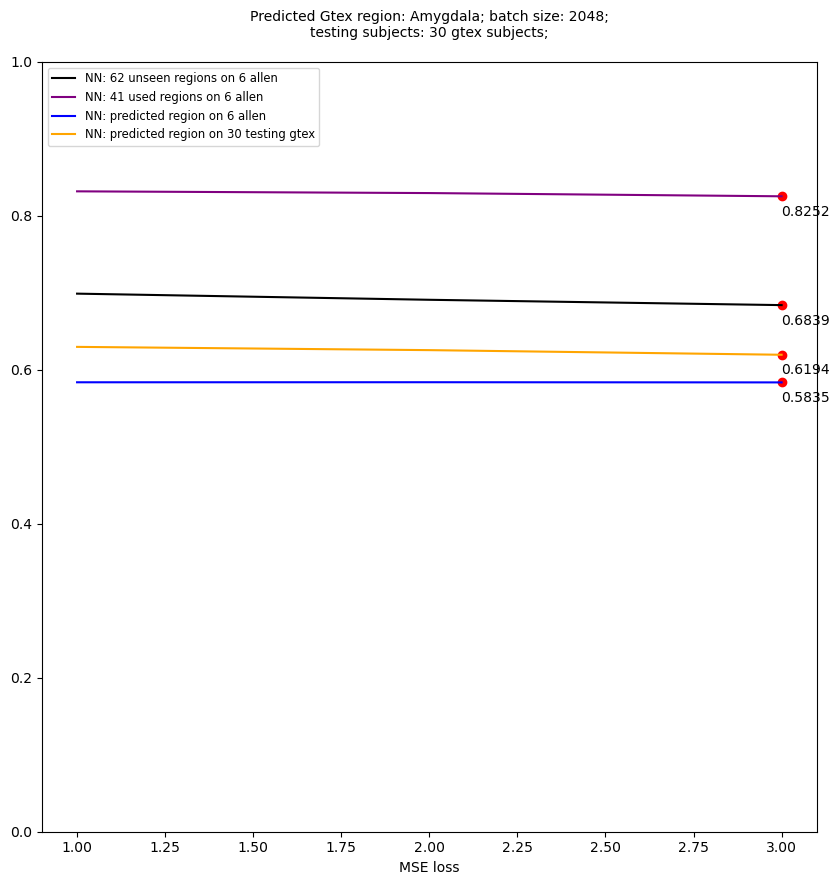

In [32]:
# plot the average loss for every epoch
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))

# find those important dots and their positions
min_nn_unseen_train = min(unseen_train_avg_loss)
min_nn_unseen_train_pos = unseen_train_avg_loss.index(min_nn_unseen_train)+1
min_nn_used_train = min(used_train_avg_loss)
min_nn_used_train_pos = used_train_avg_loss.index(min_nn_used_train)+1
min_nn_specific_train = min(specific_train_avg_loss)
min_nn_specific_train_pos = specific_train_avg_loss.index(min_nn_specific_train)+1
min_nn_specific_30_test = min(specific_30_test_avg_loss)
min_nn_specific_30_test_pos = specific_30_test_avg_loss.index(min_nn_specific_30_test)+1

ax.set_title(f"Predicted Gtex region: {pick_gtex_region}; batch size: {batchsize};\n" + 
             f"testing subjects: 30 gtex subjects;\n", size=10)
ax.set_xlabel("MSE loss")
ax.plot(range(1,1+len(unseen_train_avg_loss)), unseen_train_avg_loss, color='black', label=f"NN: {len(unseen_region_list)} unseen regions on 6 allen")
ax.plot(range(1,1+len(used_train_avg_loss)), used_train_avg_loss, color='purple', label=f"NN: {len(used_region_list)} used regions on 6 allen")
ax.plot(range(1,1+len(specific_train_avg_loss)), specific_train_avg_loss, color='blue', label="NN: predicted region on 6 allen")
ax.plot(range(1,1+len(specific_30_test_avg_loss)), specific_30_test_avg_loss, color='orange', label="NN: predicted region on 30 testing gtex")

# add annotated dots
ax.scatter(min_nn_unseen_train_pos, min_nn_unseen_train, color='red')
ax.text(min_nn_unseen_train_pos, min_nn_unseen_train-0.02, f"{min_nn_unseen_train:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(min_nn_used_train_pos, min_nn_used_train, color='red')
ax.text(min_nn_used_train_pos, min_nn_used_train-0.02, f"{min_nn_used_train:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(min_nn_specific_train_pos, min_nn_specific_train, color='red')
ax.text(min_nn_specific_train_pos, min_nn_specific_train-0.02, f"{min_nn_specific_train:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(min_nn_specific_30_test_pos, min_nn_specific_30_test, color='red')
ax.text(min_nn_specific_30_test_pos, min_nn_specific_30_test-0.02, f"{min_nn_specific_30_test:.4f}", ha="left", va="center", fontsize=10)

ax.set_ylim(0, 1)
ax.legend(loc='upper left', fontsize='small')

result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
fig_name = f'ATG_91_103_MSEcurve_{pick_gtex_region}_epoch_{epoch}'
plt.savefig(result_dir+fig_name+'.png', dpi=300, bbox_inches='tight')

## Save and Load a NN model

In [33]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'

pick_gtex_region = pick_gtex_region
epoch = 3
f_epoch = 3
lr = 0.000001
model_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_architecture.pth'
weights_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_weights.pth'
# Load the model arthitecture and weights
model = torch.load(data_dir+model_name)
model.load_state_dict(torch.load(data_dir+weights_name))

<All keys matched successfully>

## Model fine-tuning

In [34]:
# record the time
start_time = time.time()

# define the model, optimizer and loss function
finetuned_model = GO_model_91(GNN_hl1_size, r_emb_size, g_emb_size, MLP_hl1_size, MLP_hl2_size, 
                              edge_index, dropout, N_gene, N_node, n_node).to(device)
finetuned_model.load_state_dict(model.state_dict())

# Freezing the parameters of child_r
for param in finetuned_model.child_r.parameters():
    param.requires_grad = True

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=lr)

# create a dictionary to store lists of training loss and testing loss by key = region
keys = list(exp_allen_dict[all_ids[0]].columns)
explanatory_region_list = summ_9_gtex_info[all_ids[0]].columns.tolist()

allen6_allregions_loss_af = {}
allen6_unseen_loss_af, allen6_used_loss_af = [], []
# specific training average loss on the allen regions that we used to generate the predicted gtex region
allen6_specific_predicted_loss_af = []
gtex30_specific_predicted_loss_af = []

for r in keys:
    allen6_allregions_loss_af[r] = []
    
# train the model and test the model
for e in range(f_epoch):
    
    #####-----Fine tune the model on the 9 gtex regions on 30 gtex subjects-----#####
    # set model to training mode
    finetuned_model.train()
    # Freeze the weights of the gene embedding layer
    finetuned_model.gen_emb.weight.requires_grad = False
    # randomized shuffle training
    n_subject = len(sub_all_ids)
    n_region = 9
    n_samples = n_subject * n_region
    sample_shuffle = random.sample(range(n_samples), n_samples)
    for i in sample_shuffle:
        # find the subject and the region
        subject_idx = i // n_region
        subject = sub_all_ids[subject_idx]
        reg_idx = i % n_region
        reg_name = explanatory_region_list[reg_idx]
        if reg_name=='Cerebellar_Hemisphere':
            reg_name='Cerebellum'
        elif reg_name=='Frontal_Cortex_BA9':
            reg_name='Cortex'
        reg_id_list = used_intersected_region_dict[reg_name]
        reg_id_list_idx = [keys.index(x) for x in reg_id_list]
        # x exp mat
        gtex_exp_10 = exp_gtex_dict[subject]
        gtex_exp_9 = torch.tensor(gtex_exp_10.drop(pick_gtex_region, axis=1).values).to(device)
        gtex_exp_target = gtex_exp_10.loc[:,pick_gtex_region]
        targets = torch.tensor(gtex_exp_target.values).to(device)
        # shuffle the genes for training
        gene_shuffle_order = np.random.choice(N_gene, N_gene, replace=False)
        gen_ids = gene_shuffle_order
        targets = targets[gene_shuffle_order]
        gtex_exp = gtex_exp_9[gene_shuffle_order]        
        # batch training
        num_batches = int((N_gene - N_gene % batchsize) / batchsize)        
        for b in range(num_batches):
            # reset optimizer gradients
            optimizer.zero_grad()
            # forward propagation
            gen_tuple = torch.tensor(gen_ids[b*batchsize:(b+1)*batchsize], dtype=torch.long).to(device)
            x_reg_exp = gtex_exp[b*batchsize:(b+1)*batchsize].clone().float().to(device)
            pred = finetuned_model(reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, batchsize).reshape(-1).to(device)
            real = targets[b*batchsize:(b+1)*batchsize].clone().float().to(device)
            # calculate loss
            loss = criterion(pred, real)
            # backward propagation
            loss.backward()
            # update model parameters
            optimizer.step()        
            
    
    #####-----Compute the testing error on the predicted region for 30 gtex subjects-----#####
    # set model to testing mode
    finetuned_model.eval()
    # record all pred and real to compute correlation
    gtex30_f_e = 0
    reg_name = pick_gtex_region
    if reg_name=='Cerebellar_Hemisphere':
        reg_name='Cerebellum'
    elif reg_name=='Frontal_Cortex_BA9':
        reg_name='Cortex'
    reg_id_list = used_intersected_region_dict[reg_name]
    reg_id_list_idx = [keys.index(x) for x in reg_id_list]
    for subject in sub_all_ids:
        gtex_exp_10 = exp_gtex_dict[subject]
        gtex_exp_9 = gtex_exp_10.drop(pick_gtex_region, axis=1)
        gtex_exp_target = gtex_exp_10.loc[:,pick_gtex_region]
        targets = torch.tensor(gtex_exp_target.values).to(device)
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
        x_reg_exp = torch.tensor(gtex_exp_9.values).float().to(device)
        with torch.no_grad():
            concat_pred = finetuned_model(reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
        real = targets.clone().float().to(device)
        loss = criterion(concat_pred, real)
        gtex30_f_e = gtex30_f_e + loss.item()
    # compute the MSE loss
    specific_gtex30_avg = gtex30_f_e / len(sub_all_ids)
    gtex30_specific_predicted_loss_af.append(specific_gtex30_avg)

    print(f"Model Fine-tuning Epoch {e + 1}, predicted region on 30 gtex subjects: {specific_gtex30_avg};")
        
    
    #####-----Compute the error on the unseen regions on allen subjects-----#####
    # set model to training mode
    finetuned_model.eval()
    # record all pred and real to compute correlation
    train_e = {}
    for r in unseen_region_list:
        train_e[r] = 0
    for subject in all_ids:
        for r in unseen_region_list:
            reg_id = keys.index(r)
            gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
            targets = torch.tensor(exp_allen_dict[subject].loc[:,r]).to(device)
            with torch.no_grad():
                gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
                x_reg_exp = gtex_exp.clone().float().to(device)
                pred = finetuned_model([reg_id], gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
                real = targets.clone().float().to(device)
                loss = criterion(pred, real)
                train_e[r] = train_e[r] + loss.item()
    # compute the MSE loss
    train_e_total = 0
    for r in unseen_region_list:
        train_e_avg = train_e[r] / len(all_ids)
        allen6_allregions_loss_af[r].append(train_e_avg)
        train_e_total = train_e_total + train_e_avg
    train_e_total_avg = train_e_total / len(unseen_region_list)
    allen6_unseen_loss_af.append(train_e_total_avg)
    
    print(f"Model Fine-tuning Epoch {e + 1}, {len(unseen_region_list)} unseen regions on 6 allen subjects: {train_e_total_avg};")
    
    
    #####-----Compute the error on the used regions on allen subjects-----#####
    # set model to training mode
    finetuned_model.eval()
    # record all pred and real to compute correlation
    train_e = {}
    for r in used_region_list: 
        train_e[r] = 0
    for subject in all_ids:
        for r in used_region_list:
            reg_id = keys.index(r)
            gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
            targets = torch.tensor(exp_allen_dict[subject].loc[:,r]).to(device)
            with torch.no_grad():
                gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
                x_reg_exp = gtex_exp.clone().float().to(device)
                pred = finetuned_model([reg_id], gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
                real = targets.clone().float().to(device)
                loss = criterion(pred, real)
                train_e[r] = train_e[r] + loss.item()
    # compute the MSE loss
    train_e_total = 0
    for r in used_region_list:
        train_e_avg = train_e[r] / len(all_ids)
        allen6_allregions_loss_af[r].append(train_e_avg)
        train_e_total = train_e_total + train_e_avg
    train_e_total_avg = train_e_total / len(used_region_list)
    allen6_used_loss_af.append(train_e_total_avg)
    
    print(f"Model Fine-tuning Epoch {e + 1}, {len(used_region_list)} used regions on 6 allen subjects: {train_e_total_avg};")
    
    
    #####-----Compute the predicted gtex region error on allen subjects-----#####
    # set model to training mode
    finetuned_model.eval()
    # record all pred and real to compute correlation
    allen_e = 0
    reg_name = pick_gtex_region
    if reg_name=='Cerebellar_Hemisphere':
        reg_name='Cerebellum'
    elif reg_name=='Frontal_Cortex_BA9':
        reg_name='Cortex'
    reg_id_list = used_intersected_region_dict[reg_name]
    reg_id_list_idx = [keys.index(x) for x in reg_id_list]
    for subject in all_ids:
        gtex_exp = torch.tensor(summ_9_gtex_info[subject].values).to(device)
        targets = torch.tensor(summ_gtex_info[subject].loc[:,pick_gtex_region]).to(device)
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
        x_reg_exp = gtex_exp.clone().float().to(device)
        with torch.no_grad():
            concat_pred = finetuned_model(reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
        real = targets.clone().float().to(device)
        loss = criterion(concat_pred, real)
        allen_e = allen_e + loss.item()
    # compute the MSE loss
    specific_train_avg = allen_e / len(all_ids)
    allen6_specific_predicted_loss_af.append(specific_train_avg)
      
    print(f"Model Fine-tuning Epoch {e + 1}, predicted region on 6 allen subjects: {specific_train_avg};")
    

    # print the running time
    now_time = time.time()
    total_time = now_time - start_time
    print('Running time: {:.2f} seconds'.format(total_time), "\n")

Model Fine-tuning Epoch 1, predicted region on 30 gtex subjects: 0.5276198367277781;
Model Fine-tuning Epoch 1, 62 unseen regions on 6 allen subjects: 0.6627773054504909;
Model Fine-tuning Epoch 1, 41 used regions on 6 allen subjects: 0.8323275592268967;
Model Fine-tuning Epoch 1, predicted region on 6 allen subjects: 0.4729111095269521;
Running time: 55.64 seconds 

Model Fine-tuning Epoch 2, predicted region on 30 gtex subjects: 0.48465815087159475;
Model Fine-tuning Epoch 2, 62 unseen regions on 6 allen subjects: 0.6700864952177771;
Model Fine-tuning Epoch 2, 41 used regions on 6 allen subjects: 0.8315168840856086;
Model Fine-tuning Epoch 2, predicted region on 6 allen subjects: 0.4211370050907135;
Running time: 111.20 seconds 

Model Fine-tuning Epoch 3, predicted region on 30 gtex subjects: 0.46793609857559204;
Model Fine-tuning Epoch 3, 62 unseen regions on 6 allen subjects: 0.6723618613535998;
Model Fine-tuning Epoch 3, 41 used regions on 6 allen subjects: 0.8319743325918671;
Mo

In [35]:
# save the model
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
# Save the model arthitecture and weights
#model_name = f'ATG_91_103_{pick_gtex_region}_trainable_GNN_af_epoch_{epoch}_finetuning_epoch_{f_epoch}_architecture.pth'
#weights_name = f'ATG_91_103_{pick_gtex_region}_trainable_GNN_af_epoch_{epoch}_finetuning_epoch_{f_epoch}_weights.pth'
model_name = f'ATG_91_103_{pick_gtex_region}_freeze_GNN_af_epoch_{epoch}_finetuning_epoch_{f_epoch}_architecture.pth'
weights_name = f'ATG_91_103_{pick_gtex_region}_freeze_GNN_af_epoch_{epoch}_finetuning_epoch_{f_epoch}_weights.pth'
torch.save(finetuned_model.state_dict(), data_dir+weights_name)
torch.save(finetuned_model, data_dir+model_name)

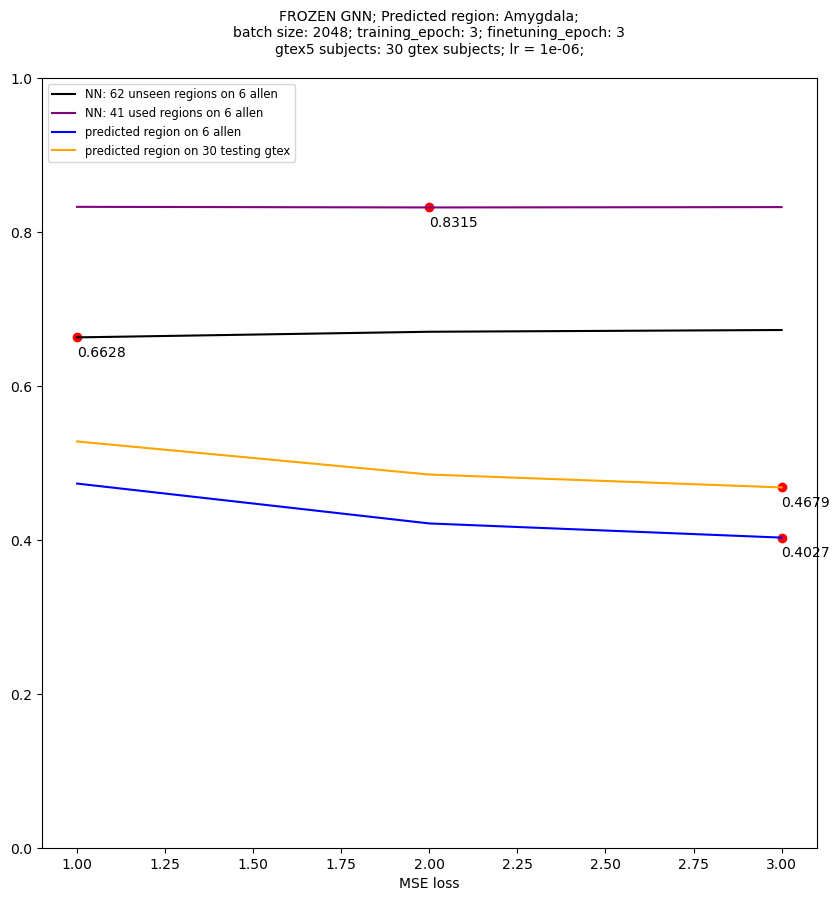

In [36]:
# Loss curve before fine tuning
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
e = len(allen6_unseen_loss_af)

# find those important dots and their positions
allen6_unseen_min = min(allen6_unseen_loss_af)
allen6_unseen_min_pos = allen6_unseen_loss_af.index(allen6_unseen_min)+1
allen6_used_min = min(allen6_used_loss_af)
allen6_used_min_pos = allen6_used_loss_af.index(allen6_used_min)+1
allen6_s_pd_min = min(allen6_specific_predicted_loss_af)
allen6_s_pd_min_pos = allen6_specific_predicted_loss_af.index(allen6_s_pd_min)+1
gtex30_s_min = min(gtex30_specific_predicted_loss_af)
gtex30_s_min_pos = gtex30_specific_predicted_loss_af.index(gtex30_s_min)+1

ax.set_title(f"FROZEN GNN; Predicted region: {pick_gtex_region};\n" + 
             f"batch size: {batchsize}; training_epoch: {epoch}; finetuning_epoch: {f_epoch}\n" + 
             f"gtex5 subjects: 30 gtex subjects; lr = {lr};\n", size=10)
ax.set_xlabel("MSE loss")
ax.plot(range(1,1+e), allen6_unseen_loss_af, color='black', label=f"NN: {len(unseen_region_list)} unseen regions on 6 allen")
ax.plot(range(1,1+e), allen6_used_loss_af, color='purple', label=f"NN: {len(used_region_list)} used regions on 6 allen")
ax.plot(range(1,1+e), allen6_specific_predicted_loss_af, color='blue', label="predicted region on 6 allen")
ax.plot(range(1,1+e), gtex30_specific_predicted_loss_af, color='orange', label="predicted region on 30 testing gtex")

# add annotated dots
ax.scatter(allen6_unseen_min_pos, allen6_unseen_min, color='red')
ax.text(allen6_unseen_min_pos, allen6_unseen_min-0.02, f"{allen6_unseen_min:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(allen6_used_min_pos, allen6_used_min, color='red')
ax.text(allen6_used_min_pos, allen6_used_min-0.02, f"{allen6_used_min:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(allen6_s_pd_min_pos, allen6_s_pd_min, color='red')
ax.text(allen6_s_pd_min_pos, allen6_s_pd_min-0.02, f"{allen6_s_pd_min:.4f}", ha="left", va="center", fontsize=10)
ax.scatter(gtex30_s_min_pos, gtex30_s_min, color='red')
ax.text(gtex30_s_min_pos, gtex30_s_min-0.02, f"{gtex30_s_min:.4f}", ha="left", va="center", fontsize=10)

ax.set_ylim(0, 1)
ax.legend(loc='upper left', fontsize='small')

result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
fig_name = f'ATG_MSEcurve_91_finetuning_{pick_gtex_region}_epoch_{epoch}_f_epoch_{f_epoch}'
plt.savefig(result_dir+fig_name+'.png', dpi=300, bbox_inches='tight')